# Grouped Search for Device Comparisons

This notebook demonstrates PyMAUDE's grouped search functionality for comparing multiple device categories.


## What You'll Learn

1. Dict-based grouped search syntax
2. Working with the `search_group` column
3. Using helper functions with grouped results
4. Comparative analysis across device types
5. Handling overlapping results

## Setup

In [1]:
from pymaude import MaudeDatabase
import pandas as pd
import matplotlib.pyplot as plt

# Create database and download data
# db = MaudeDatabase('notebooks.db', verbose=True)
# db.add_years('2020-2023', tables=['device', 'master'], download=True)
# db.create_search_index()

db = MaudeDatabase('../analysis/venous_thrombectomy/maude_2008_2025.db', verbose=True)


print("Setup complete!")

Setup complete!


## 1. Basic Grouped Search

Use a dictionary to search for multiple device categories at once. Each key becomes a group name in the results:

In [2]:
# Compare mechanical vs aspiration thrombectomy devices
results = db.search_by_device_names({
    'mechanical': [['argon', 'cleaner'], 'angiojet'],  # (argon AND cleaner) OR angiojet
    'aspiration': ['penumbra']                            # penumbra
})

print(f"Total events: {len(results)}")
print(f"\nGroups found: {results['search_group'].unique()}")
print(f"\nEvents by group:")
print(results['search_group'].value_counts())

Total events: 23304

Groups found: ['mechanical' 'aspiration']

Events by group:
search_group
aspiration    21334
mechanical     1970
Name: count, dtype: int64


### The search_group Column

When you use dict input, the results include a `search_group` column tracking which group each event belongs to:

In [3]:
# View some results
print(results[['search_group', 'BRAND_NAME', 'GENERIC_NAME', 'DATE_RECEIVED']].head(10))

  search_group                                       BRAND_NAME  \
0   mechanical  ANGIOJET SPIROFLEX RAPID EXCHANGE (RX) CATHETER   
1   mechanical     ANGIOJET XPEEDIOR RHEOLYTIC THROMBECTOMY SET   
2   mechanical                                         ANGIOJET   
3   mechanical          ANGIOJET DVX RHEOLYTIC THROMBECTOMY SET   
4   mechanical         ANGIOJET RHEOLYTIC THROMBECTOMY CATHETER   
5   mechanical                  ANGIOJET ULTRA THROMBECTOMY SET   
6   mechanical                          ANGIOJET ULTRA XPEEDIOR   
7   mechanical                               ANGIOJET ULTRA XMI   
8   mechanical                               ANGIOJET ULTRA AVX   
9   mechanical                               ANGIOJET ULTRA XVG   

           GENERIC_NAME        DATE_RECEIVED  
0             SPIROFLEX  2008-01-22 00:00:00  
1  EMBOLECTOMY CATHETER  2008-02-04 00:00:00  
2    ANGIOJET SPIROFLEX  2008-01-28 00:00:00  
3  EMBOLECTOMY CATHETER  2008-02-08 00:00:00  
4  EMBOLECTOMY CATHETER  20

### You can also choose not to use groups

If groups aren't needed, recall from `01_getting_started.ipynb` that `search_by_device_names()` can also be used with a list as input:

In [4]:
results_OR = db.search_by_device_names(['pacemaker', 'defibrillator']) # pacemaker OR defibrillator
results_AND = db.search_by_device_names([['pacemaker', 'defibrillator']]) # pacemaker AND defibrillator

print(f"Found {len(results_OR)} events (pacemaker OR defibrillator)")
print(f"Found {len(results_AND)} events (pacemaker AND defibrillator)")

Found 1332062 events (pacemaker OR defibrillator)
Found 51308 events (pacemaker AND defibrillator)


## 2. Complex Group Criteria

Each group can have its own complex boolean logic:

In [5]:
# Compare different stent types
results = db.search_by_device_names({
    'coronary': [['coronary', 'stent']],                    # coronary AND stent
    'venous': [['venous', 'stent'], 'iliac stent'],        # (venous AND stent) OR "iliac stent"
    'peripheral': [['peripheral', 'stent'], 'vascular stent'],  # (peripheral AND stent) OR "vascular stent"
    'medtronic': [['medtronic', 'stent']]    # medtronic AND stent -- search terms can be desriptors, brands, or models
}, start_date='2020-01-01')

print(f"Total stent events: {len(results)}")
print(f"\nBreakdown by stent type:")
counts = results['search_group'].value_counts()
for group, count in counts.items():
    pct = 100 * count / len(results)
    print(f"  {group}: {count} ({pct:.1f}%)")

/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 36 events previously matched to other groups were skipped from 'peripheral'
  warnings.warn(


Total stent events: 40394

Breakdown by stent type:
  coronary: 26371 (65.3%)
  peripheral: 8468 (21.0%)
  medtronic: 3461 (8.6%)
  venous: 2094 (5.2%)


/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 6179 events previously matched to other groups were skipped from 'medtronic'
  warnings.warn(


## 3. Using Helper Functions with Grouped Results

Helper functions automatically use the `search_group` column for analysis:

### Trends Over Time

In [6]:
# Get thrombectomy device events
results = db.search_by_device_names({
    'stents': [['venous', 'stent']],
    'pacemakers': [['cardiac', 'pacemaker'], ['heart', 'pacemaker']]
}, start_date='2020-01-01')

# Get trends - automatically includes search_group breakdown
trends = db.get_trends_by_year(results)

print("Yearly trends by device type:")
print(trends)

Yearly trends by device type:
   search_group  year  event_count
0    pacemakers  2020          593
1    pacemakers  2021          880
2    pacemakers  2022          972
3    pacemakers  2023         1270
4    pacemakers  2024         1417
5    pacemakers  2025         1881
6        stents  2020          102
7        stents  2021          394
8        stents  2022          119
9        stents  2023          215
10       stents  2024          114
11       stents  2025          182


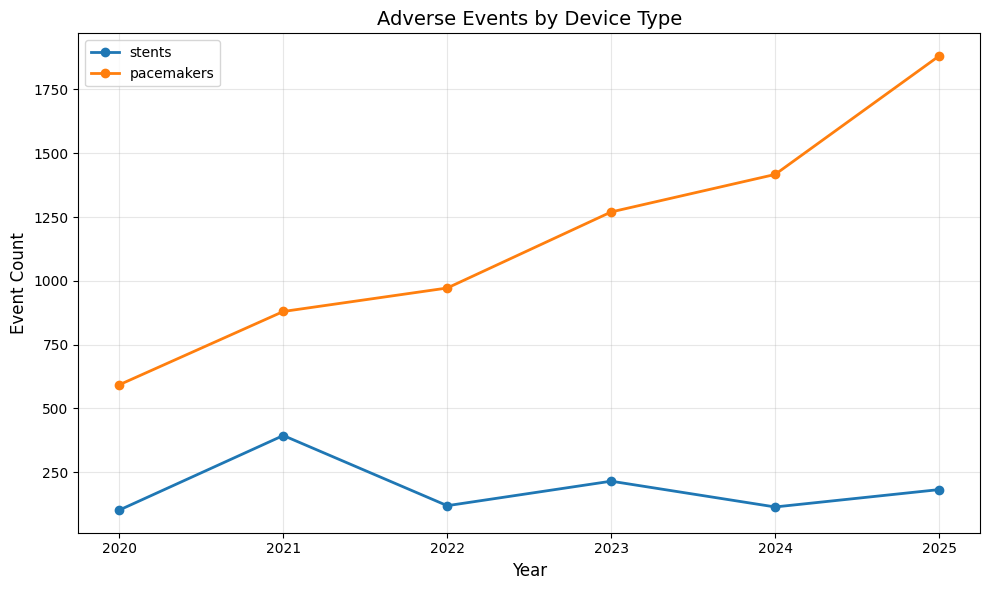

In [7]:
# Visualize trends
plt.figure(figsize=(10, 6))

for group in results['search_group'].unique():
    group_trends = trends[trends['search_group'] == group]
    plt.plot(group_trends['year'], group_trends['event_count'], marker='o', label=group, linewidth=2)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.title('Adverse Events by Device Type', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Summary Statistics

In [8]:
# Get summary by group (automatically uses search_group)
summary = db.summarize_by_brand(results)

print("Event counts by group:")
print(summary['counts'])

print("\nEvent type breakdown:")
print(summary['event_types'])

Event counts by group:
{'pacemakers': 7013, 'stents': 1126}

Event type breakdown:
EVENT_TYPE      D    IN     M  O
search_group                    
pacemakers    101  3977  2933  2
stents          4   424   698  0


### Event Type Comparison

In [9]:
# Compare event type distributions across groups
comparison = db.event_type_comparison(results)

print("Event type comparison:")
print(comparison['summary'])

print("\nStatistical test:")
print(comparison['chi2_test'])

Event type comparison:
Event Type Comparison by search_group
Chi-square: 162.41 (p=0.0000)

pacemakers: 1.4% deaths, 56.7% injuries, 41.8% malfunctions
stents: 0.4% deaths, 37.7% injuries, 62.0% malfunctions

Statistical test:
{'chi2_statistic': 162.40843804382635, 'p_value': 5.4132211691841664e-36, 'dof': 2, 'expected_frequencies': event_type    has_death   has_injury  has_malfunction
search_group                                         
pacemakers    90.470075  3791.988571      3128.541354
stents        14.529925   609.011429       502.458646, 'significant': np.True_}


## 4. Analyzing Individual Groups

Filter to a single group for detailed analysis:

In [10]:
# Get grouped search results
results = db.search_by_device_names({
    'pacemaker': 'pacemaker',
    'defibrillator': 'defibrillator',
    'icd': ['icd', 'implantable cardioverter']
})

# Filter to pacemaker group only
pacemaker_only = results[results['search_group'] == 'pacemaker']

print(f"Pacemaker events: {len(pacemaker_only)}")
print(f"\nTop pacemaker brands:")
print(pacemaker_only['BRAND_NAME'].value_counts().head())

/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 51328 events previously matched to other groups were skipped from 'defibrillator'
  warnings.warn(
/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 379622 events previously matched to other groups were skipped from 'icd'
  warnings.warn(


Pacemaker events: 640629

Top pacemaker brands:
BRAND_NAME
CAPSUREFIX NOVUS LEAD MRI SURESCAN    96209
CAPSUREFIX NOVUS                      41832
TENDRIL STS                           37117
TENDRIL ST                            17654
ASSURITY MRI                          17605
Name: count, dtype: int64


In [11]:
# Get trends for single group
pacemaker_trends = db.get_trends_by_year(pacemaker_only)

print("Pacemaker trends:")
print(pacemaker_trends)

# Note: search_group column may still be present if it was in the original DataFrame

Pacemaker trends:
   search_group  year  event_count
0     pacemaker  2008        17146
1     pacemaker  2009         6407
2     pacemaker  2010        10889
3     pacemaker  2011        12921
4     pacemaker  2012        13867
5     pacemaker  2013        23434
6     pacemaker  2014        34355
7     pacemaker  2015        30567
8     pacemaker  2016        26888
9     pacemaker  2017        29667
10    pacemaker  2018        38228
11    pacemaker  2019        50347
12    pacemaker  2020        51408
13    pacemaker  2021        53260
14    pacemaker  2022        58272
15    pacemaker  2023        71103
16    pacemaker  2024        50493
17    pacemaker  2025        61377


## 5. Date Filtering with Groups

Date filters apply to all groups:

In [12]:
# Compare recent events only
recent = db.search_by_device_names(
    {
        'insulin_pump': ['insulin pump', ['insulin', 'pump']],
        'cgm': ['continuous glucose', 'cgm', ['glucose', 'monitor']],
        'blood_glucose': ['glucometer', 'blood glucose meter']
    },
    start_date='2022-01-01',
    end_date='2023-12-31'
)

print(f"Diabetes device events (2022-2023): {len(recent)}")
print(f"\nBreakdown:")
print(recent['search_group'].value_counts())

/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 11 events previously matched to other groups were skipped from 'cgm'
  warnings.warn(
/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 92 events previously matched to other groups were skipped from 'blood_glucose'
  warnings.warn(


Diabetes device events (2022-2023): 1252212

Breakdown:
search_group
insulin_pump     634502
cgm              617371
blood_glucose       339
Name: count, dtype: int64


## 6. Understanding Overlap Handling

Events matching multiple groups only appear in the FIRST matching group (based on dict order):

In [13]:
# Example with potential overlap
results = db.search_by_device_names({
    'all_catheters': 'catheter',           # Broad search
    'specific_type': 'cardiac catheter'    # More specific - but will miss events already in first group
})

# Events matching "cardiac catheter" appear ONLY in 'all_catheters' (first group)
# Warnings are issued during search

print(f"All catheters: {(results['search_group'] == 'all_catheters').sum()}")
print(f"Specific type: {(results['search_group'] == 'specific_type').sum()}")
print("\nNote: 'specific_type' count may be lower due to overlap with 'all_catheters'")

All catheters: 549503
Specific type: 0

Note: 'specific_type' count may be lower due to overlap with 'all_catheters'


/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 185 events previously matched to other groups were skipped from 'specific_type'
  warnings.warn(


### Best Practice: Order Groups from Specific to General

In [14]:
# Better approach - specific groups first
results = db.search_by_device_names({
    'cardiac_catheter': ['cardiac catheter', ['cardiac', 'catheter']],  # Specific first
    'other_catheters': 'catheter'                                        # General last
})

print(f"Cardiac catheters: {(results['search_group'] == 'cardiac_catheter').sum()}")
print(f"Other catheters: {(results['search_group'] == 'other_catheters').sum()}")

/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 37160 events previously matched to other groups were skipped from 'other_catheters'
  warnings.warn(


Cardiac catheters: 37160
Other catheters: 512343


## 7. Real-World Example: Venous Thromboembolism Device Comparison

In [15]:
# Compare different VTE treatment modalities
vte_devices = db.search_by_device_names(
    {
        'mechanical_thrombectomy': [
            ['argon', 'cleaner'], 
            ['cleaner', 'xt'],
            'angiojet',
            ['angiojet', 'zelante']
        ],
        'aspiration_thrombectomy': [
            ['penumbra', 'indigo'],
            ['penumbra', 'lightning'],
            'indigo'
        ],
        'retrieval_system': [
            'flowtriever',
            ['inari', 'flowtriever']
        ],
        'venous_stent': [
            'venovo',
            ['venous', 'stent'],
            'venous stent'
        ]
    },
    start_date='2019-01-01',
    end_date='2023-12-31'
)

print(f"Total VTE device events (2019-2023): {len(vte_devices)}")
print(f"\nEvents by modality:")
modality_counts = vte_devices['search_group'].value_counts().sort_values(ascending=False)
for modality, count in modality_counts.items():
    pct = 100 * count / len(vte_devices)
    print(f"  {modality}: {count:,} ({pct:.1f}%)")

Total VTE device events (2019-2023): 3442

Events by modality:
  aspiration_thrombectomy: 1,891 (54.9%)
  venous_stent: 847 (24.6%)
  mechanical_thrombectomy: 693 (20.1%)
  retrieval_system: 11 (0.3%)


In [16]:
# Compare event types across modalities
comparison = db.event_type_comparison(vte_devices)

print("Event type distribution by modality:")
print(comparison['summary'])

if comparison['chi2_test']['p_value'] < 0.05:
    print(f"\n✓ Statistically significant difference (p={comparison['chi2_test']['p_value']:.4f})")
else:
    print(f"\n✗ No significant difference (p={comparison['chi2_test']['p_value']:.4f})")

Event type distribution by modality:
Event Type Comparison by search_group
Chi-square: 375.35 (p=0.0000)

aspiration_thrombectomy: 1.9% deaths, 7.0% injuries, 91.1% malfunctions
mechanical_thrombectomy: 2.0% deaths, 10.0% injuries, 87.9% malfunctions
retrieval_system: 18.2% deaths, 54.5% injuries, 27.3% malfunctions
venous_stent: 0.4% deaths, 32.8% injuries, 66.8% malfunctions

✓ Statistically significant difference (p=0.0000)


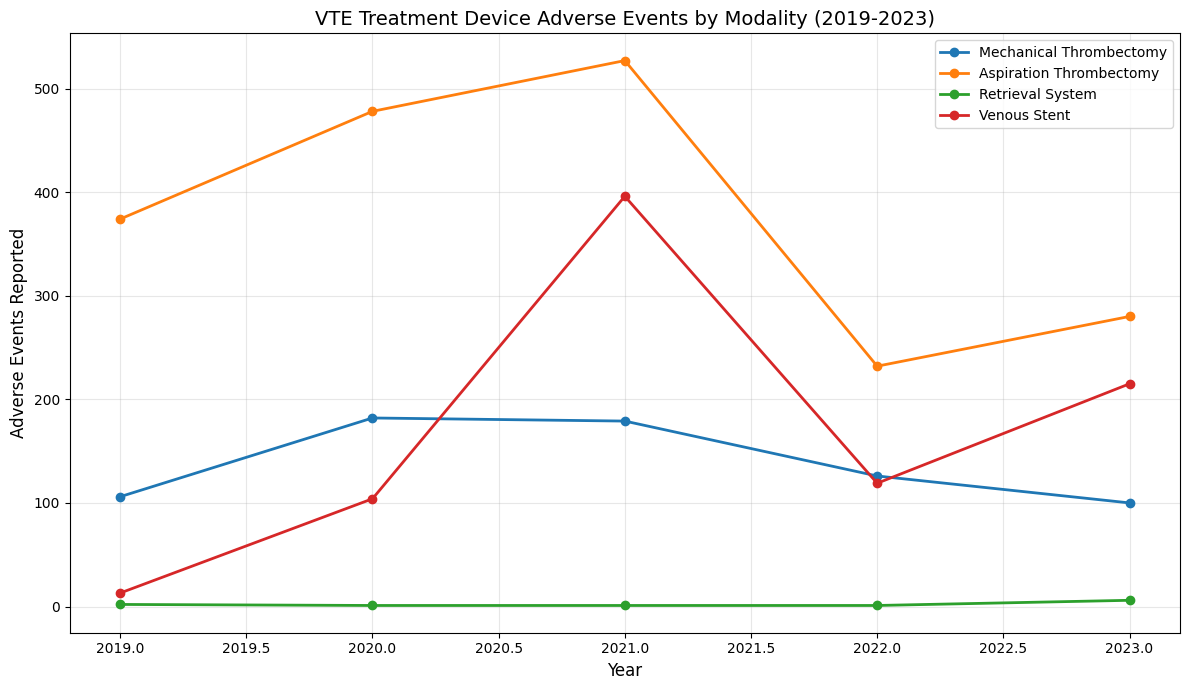

In [17]:
# Visualize trends
trends = db.get_trends_by_year(vte_devices)

plt.figure(figsize=(12, 7))

for modality in vte_devices['search_group'].unique():
    modality_trends = trends[trends['search_group'] == modality]
    plt.plot(modality_trends['year'], modality_trends['event_count'], 
             marker='o', label=modality.replace('_', ' ').title(), linewidth=2)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Adverse Events Reported', fontsize=12)
plt.title('VTE Treatment Device Adverse Events by Modality (2019-2023)', fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Exporting Grouped Results

In [18]:
# Export results with search_group column
vte_devices.to_csv('vte_devices_by_modality.csv', index=False)

print(f"Exported {len(vte_devices)} records to vte_devices_by_modality.csv")
print(f"Includes search_group column for filtering in Excel/R/other tools")

Exported 3442 records to vte_devices_by_modality.csv
Includes search_group column for filtering in Excel/R/other tools


## Cleanup

In [19]:
db.close()
print("Database closed.")

Database closed.


## Summary

Key takeaways:

1. **Dict syntax**: `db.search_by_device_names({'group1': criteria1, 'group2': criteria2})`
2. **Results include `search_group` column** for tracking group membership
3. **Helper functions automatically use `search_group`** for grouping
4. **First-match-wins**: Events only appear in first matching group
5. **Order matters**: Put specific groups before general ones
6. **Date filters apply to all groups**

## Next Steps

- **03_exact_queries.ipynb** - Precise field-based queries
- **04_analysis_helpers.ipynb** - Comprehensive helper function guide
- **05_advanced_workflows.ipynb** - Complex real-world workflows